<a href="https://colab.research.google.com/github/Jkimoon/2025S/blob/main/IO2_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyblp

In [ ]:
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.0'

#Load Data

In [ ]:
# load data
os.chdir("C:\Users\jkm\OneDrive - University of Virginia\5. 2025_Spring\1. Industrial Organization\Homework\Homework3")
product_data = pd.read_csv("airline_data_prepared.csv")
# Adjust 'simpleshare' based on the given conditions
# product_data['simpleshare'] = -0.000001
# If value is greater than or equal to 1, set it to 0.999999
# product_data.loc[product_data['simpleshare'] >= 1, 'simpleshare'] = 0.999999
# If value is 0, set it to 0.000001
# product_data.loc[product_data['simpleshare'] <= 0, 'simpleshare'] = 0.000001

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-9-60d716df3697>, line 2)

In [ ]:
# Rename variables
product_data = product_data.rename(columns={'averageprice': 'prices'})
product_data = product_data.rename(columns={'market': 'market_ids'})
product_data = product_data.rename(columns={'airline_market_share': 'shares'})
product_data = product_data.rename(columns={'tkcarrier': 'firm_ids'})
# Rename IV's
product_data = product_data.rename(columns={'AirlineDestinationPresence': 'demand_instruments0'})
product_data.head()

,market_ids,firm_ids,marketdistanceticket,OAGnonstop,origin,dest,airportmarketsize,prices,totalpassengers,market_nodirection,...,AirportNetwork_dest,AirlineOriginPresence,demand_instruments0,total_market_passengers,simpleshare,market_total_passengers,marketsize,inside_share,outside_share,shares
0,ACYATL,NK,0.677444,1.000000,ACY,ATL,6146834.5,0.773634,2200,ACYATL,...,66,1.0,0.348485,2200,1.0,2200,6146834.5,0.000358,0.999642,0.000358
1,ACYDFW,NK,1.326746,0.000000,ACY,DFW,6883516.5,1.360923,140,ACYDFW,...,65,1.0,0.400000,140,1.0,140,6883516.5,0.000020,0.999980,0.000020
2,ACYFLL,NK,0.978535,0.974646,ACY,FLL,6248623.5,0.757178,13410,ACYFLL,...,64,1.0,0.453125,13410,1.0,13410,6248623.5,0.002146,0.997854,0.002146
3,ACYIAH,NK,1.342880,0.000000,ACY,IAH,6658437.5,1.381371,130,ACYIAH,...,64,1.0,0.390625,130,1.0,130,6658437.5,0.000020,0.999980,0.000020
4,ACYLAS,NK,2.208158,0.000000,ACY,LAS,3761303.0,1.124277,190,ACYLAS,...,66,1.0,0.424242,190,1.0,190,3761303.0,0.000051,0.999950,0.000051


# 1.2

In [ ]:
# set up problem
logit_formulation = pyblp.Formulation('prices + marketdistanceticket + AirlineOriginPresence', absorb='C(firm_ids)')
logit_formulation

prices + marketdistanceticket + AirlineOriginPresence + Absorb[C(firm_ids)]

In [ ]:
# display problem
problem = pyblp.Problem(logit_formulation, product_data)
problem

Dimensions:
 T      N     F    K1    MD    ED 
----  -----  ---  ----  ----  ----
4019  14315   8    3     3     1  

Formulations:
     Column Indices:          0              1                      2          
--------------------------  ------  --------------------  ---------------------
X1: Linear Characteristics  prices  marketdistanceticket  AirlineOriginPresence

In [ ]:
#solve problem
logit_results = problem.solve()
logit_results

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +4.2E-27      0         +5.0E+01          +7.3E+02     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
  prices    marketdistanceticket  AirlineOriginPresence
----------  --------------------  ---------------------
 -2.4E+01         +8.6E+00              +1.3E+00       
(+2.4E+00)       (+9.1E-01)            (+7.4E-01)      

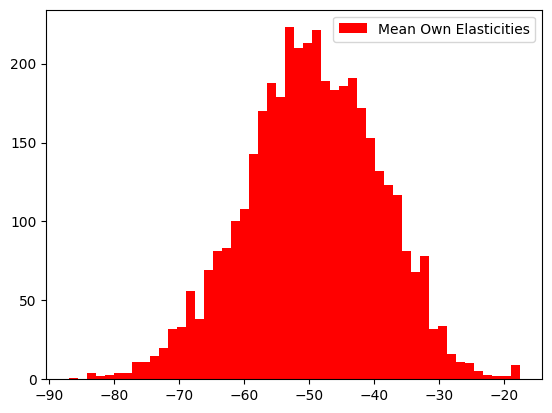

In [ ]:
#elasticities
elasticities = logit_results.compute_elasticities()
means = logit_results.extract_diagonal_means(elasticities)

plt.hist(
    [means.flatten()],
    color=['red'],
    bins=50
);
plt.legend(['Mean Own Elasticities']);

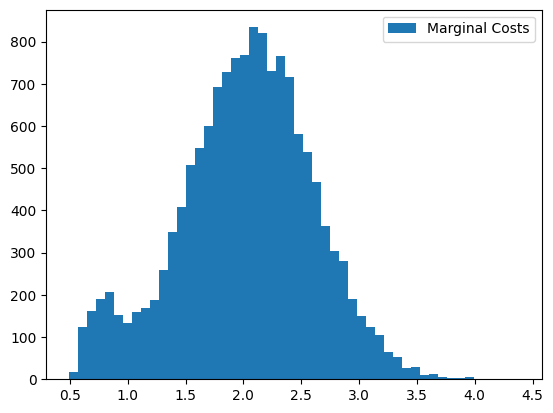

In [ ]:
# MC
costs = logit_results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);

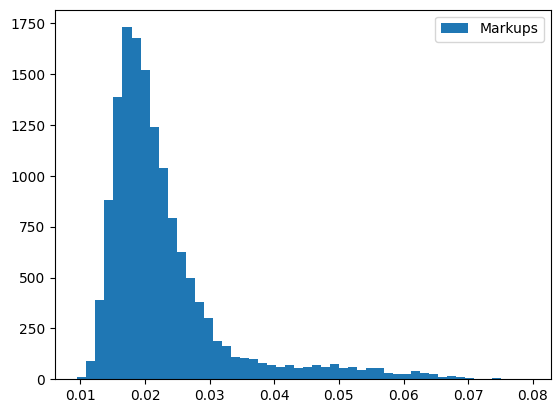

In [ ]:
markups = logit_results.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

# 1.3